In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

In [2]:
train_texts = []
train_labels = []
test_texts = []
test_labels = []
for i in ['train','test']:
    for category in ['pos','neg']:
        path = os.path.join('aclImdb', i, category)
        for fname in sorted(os.listdir(path)):
            if fname.endswith('.txt'):
                with open(os.path.join(path,fname)) as f:
                    if i == "train":
                        train_texts.append(f.read())
                        train_labels.append(0 if category == 'neg' else 1)
                    else:
                        test_texts.append(f.read())
                        test_labels.append(0 if category == 'neg' else 1)


In [3]:
np.median([len(s.split()) for s in train_texts])

174.0

In [4]:
def shuffle(X, y):
    perm = np.random.permutation(len(X))
    X = X[perm]
    y = y[perm]
    return X, y

In [5]:
train_texts = np.array(train_texts)
train_labels = np.array(train_labels)
test_texts = np.array(test_texts)
test_labels = np.array(test_labels)
train_texts,train_labels = shuffle(train_texts,train_labels)
test_texts,test_labels = shuffle(test_texts,test_labels)

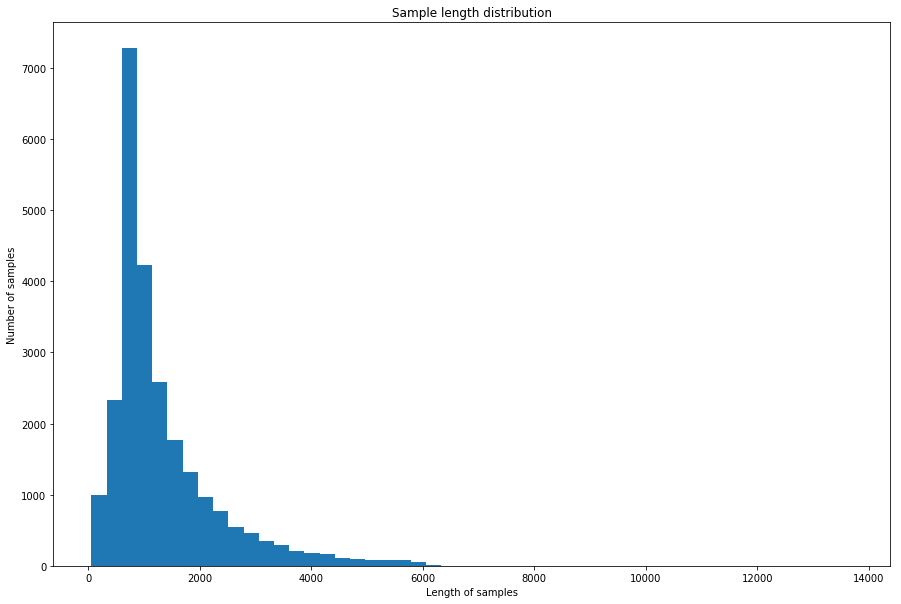

In [6]:
plt.figure(figsize=(15, 10))
plt.hist([len(sample) for sample in list(train_texts)], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

In [7]:
def ngram_vectorize(train_texts, train_labels, val_texts):

    kwargs = {
            'ngram_range': (1, 2),  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
            'min_df': 2,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    x_train = vectorizer.fit_transform(train_texts)

    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(20000, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [26]:

# Vectorize the data
x_train, x_val = ngram_vectorize(train_texts, train_labels, test_texts)

model = Sequential()
# model.add(Dense(units=128, activation='relu',input_shape=x_train.shape[1:]))
model.add(Dropout(0.2,input_shape=x_train.shape[1:] ))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation="sigmoid"))

print(model.summary())

learning_rate=1e-3
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

# Create callback for early stopping on validation loss. If the loss does
# not decrease on two consecutive tries, stop training
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

# Train and validate model
history = model.fit(x_train, train_labels, epochs=100, validation_data=(x_val, test_labels),
                    verbose=2, batch_size=128, callbacks=callbacks)

# Print results
history = history.history
val_acc = history['val_acc'][-1]
val_loss = history['val_loss'][-1]
print ('Validation accuracy: {acc}, loss: {loss}'.format(
        acc=val_acc, loss=val_loss))

# Save model
model.save('IMDB_mlp_model_' + str(val_acc) + '_' + str('binary_crossentropy') + '.h5')
#     return val_acc, val_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_17 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                1280064   
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/100
 - 13s - loss: 0.4697 - acc: 0.8549 - val_loss: 0.3227 - val_acc: 0.8874
Epoch 2/100
 - 12s - loss: 0.2345 - acc: 0.9175 - val_loss: 0.2520 - val_acc: 0.9010
Epoch 3/100
 - 11s - loss: 0.1699 - acc